In [1]:
import numpy as np
from scipy.integrate import odeint
import dill
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import plotly.graph_objects as go

In [2]:
EXTRA_SMALL_SIZE = 17
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rcParams['lines.linewidth'] = 2.5

In [3]:
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=EXTRA_SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
GAMMA = 1/14
SIGMA = 1/5
DECLARE_PANDEMIC = '2020-03-11'
ALL_STATES_EMERGENCY = '2020-03-22'

In [5]:
# ---------- MODEL -------------- #

In [6]:
def to_idx(dates, date):
    return np.argwhere(dates == date)[0][0]

In [7]:
def delta_flight_seir(x, t, params, n, exp_in, exp_out, min_t, max_t):
    s, e, i, r = x
    beta, sigma, gamma = params
    t = min(max(min_t, t), max_t)
    in_e = exp_in(t) / n
    out_e = exp_out(t) / n
    ds = - beta * s * i 
    de = beta * s * i + in_e - min(sigma * e + out_e, e)
    di = sigma * e - min(gamma * i, i) 
    dr = gamma * i
    return [ds, de, di, dr]

In [8]:
def delta_seir(x, t, params, n, exp_in, exp_out, min_t, max_t):
    s, e, i, r = x
    beta, sigma, gamma = params
    ds = - beta * s * i 
    de = beta * s * i - sigma * e
    di = sigma * e - gamma * i 
    dr = gamma * i
    return [ds, de, di, dr]

In [9]:
FLIGHT_SEIR = delta_flight_seir
SEIR = delta_seir

In [10]:
# ---------- MODEL -------------- #

In [11]:
# ---------- UTILS -------------- #

In [12]:
def to_plt_date(date_str):
    return matplotlib.dates.date2num(date.fromisoformat(date_str))

In [13]:
#Assumption: E = I/ 2.5
def get_seir_by_date(df_target, date):
    df_by_date = df_target[df_target.index == date].iloc[0]
    seir = np.zeros(shape=4)
    seir[1] = df_by_date['i'] / 2.75
    seir[2] = df_by_date['i']
    seir[3] = df_by_date['r']
    seir[0] = 1 - seir[1] - seir[2] - seir[3]
    return seir

In [14]:
def get_date_range(dates, start_date, end_date):
    return dates[(dates >= start_date) & (dates <= end_date)]

In [15]:
def find_best_R0(true_y, pred_y, R0_range):
    losses = np.zeros(len(R0_range))
    for idx, _ in enumerate(R0_range):
        losses[idx] = mean_squared_error(true_y, pred_y[idx, :])   
    return np.argmin(losses)

In [16]:
def run_sim(data, start_date, end_date, R0_range, exp_in, exp_out, model):
    betas = np.array([r0 * GAMMA for r0 in R0_range])
    seir_0 = get_seir_by_date(data.df_target, start_date)
    date_range = get_date_range(data.dates, start_date, end_date)
    seirs = np.zeros(shape=(len(betas), len(date_range), 4))
    for idx, beta in enumerate(betas):
        params = beta, SIGMA, GAMMA
        seirs[idx] = odeint(model, y0=seir_0, t=date_range.dayofyear, rtol=1e-8, args=(params, data.n, exp_in, exp_out, data.min_t, data.max_t))
    return date_range, seirs

In [17]:
def fit_R0(data, start_date, end_date, R0_range, model):
    x, seirs = run_sim(data, start_date, end_date, R0_range, data.exp_in, data.exp_out, model)
    pred_y = seirs[:, :, 2]
    true_y = data.df_target[data.df_target.index.isin(x)]['i'].to_numpy()
    start_idx = max(0, pd.to_datetime('2020-04-22').dayofyear - pd.to_datetime(start_date).dayofyear)
    best_idx = find_best_R0(true_y[start_idx:], pred_y[:, start_idx:], R0_range)
    return x, seirs, best_idx 

In [18]:
# ---------- UTILS -------------- #

In [19]:
# ---------- PLOTS -------------- #

In [30]:
def plot_early_time_prediction(x, y, labels, target, restrict_travel):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111)
    df1 = pd.DataFrame(y[:-1].transpose() * 100, x, labels)
    df2 = pd.DataFrame(y[-1].transpose() * 100, x, ["Data"])
    sns.lineplot(data=df1, palette=sns.cubehelix_palette(y.shape[0] - 1, start=0, rot=0), dashes=False, ax=ax)
    sns.scatterplot(data=df2, palette=sns.color_palette("Reds", 1), markers=['X'], ax=ax)
    ax.set_xlabel('Date')
    ax.set_ylabel('Infected, %')
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 14))
    ax.xaxis.set_tick_params(rotation=15)
    if DECLARE_PANDEMIC in x:
#         date_idx = to_idx(x, np.datetime64(DECLARE_PANDEMIC)) 
#         print("DECLARE_PANDEMIC", y[:, date_idx] * data.n)
        plt.axvline(x=to_plt_date(DECLARE_PANDEMIC), ls='--', label='WHO Declared COVID as Pandemic', c='black')
#         date_idx = to_idx(x, np.datetime64(ALL_STATES_EMERGENCY))
#         print("STATE EMERGENCY", y[:, date_idx] * data.n)
        plt.axvline(x=to_plt_date(ALL_STATES_EMERGENCY), ls='--', label='All Provinces Declared State of Emergency', c='grey')
#     date_idx = np.argwhere(x.to_numpy() ==  np.datetime64('2020-03-22'))[0][0]
#     print("2020-03-22", y[:, date_idx])
#     date_idx = np.argwhere(x.to_numpy() ==  np.datetime64('2020-04-22'))[0][0]
#     print("2020-04-22", y[:, date_idx])
    plt.axhline(y = 0.03, ls='--', label='Outbreak Warning 0.03%', c='orange')
    plt.axhline(y = 0.05, ls='--', label='Outbreak Warning 0.05%', c='darkorange')
    plt.axhline(y = 0.1, ls='--', label='Outbreak Warning 0.1%', c='red')
    plt.legend()
    if restrict_travel:
#         plt.title("Early Time Prediction with Travel Restriction: " + target)
        plt.savefig('../../graphs/covid/early_time_prediction_%s_with_travel_restriction.png' % target, bbox_inches='tight')
    else:
#         plt.title("Early Time Prediction without Travel Restriction: " + target)
        plt.savefig('../../graphs/covid/early_time_prediction_%s_without_travel_restriction.png' % target, bbox_inches='tight')

In [28]:
def plot_early_time_fit(flight_seir, late_start_seir, early_start_seir, true_seir, end_date, target):
    x_fseir, y_fseir, labels_fseir, best_idx_fseir, range_fseir = flight_seir
    x_seir1, y_seir1, labels_seir, best_idx_seir1, range_seir = late_start_seir
    x_seir2, y_seir2, _, _, _ = early_start_seir
    pal = ['coral', 'slateblue', 'darkslateblue', 'lightcoral']
    
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111)
    
    plt_dates1 = matplotlib.dates.date2num(x_fseir.to_pydatetime())
    plt_dates2 = matplotlib.dates.date2num(x_seir1.to_pydatetime())
    line = None
    for idx, label in enumerate(labels_fseir[0:-1]):
        if idx != best_idx_fseir:
            line = ax.plot_date(plt_dates1, y_fseir[idx] * 100, '-', c=pal[0], zorder=0, alpha=0.2)
    line[0].set_label('FlightSEIR R0 Range: [%0.2f, %0.2f]' % (range_fseir[0], range_fseir[-1]))
    ax.plot_date(plt_dates1, y_fseir[best_idx_fseir] * 100,'-', c=pal[0], label='Best Fit ' + labels_fseir[best_idx_fseir])

    for idx, label in enumerate(labels_seir[0:-1]):
        if idx != best_idx_seir1:
            line = ax.plot_date(plt_dates2, y_seir1[idx] * 100, '-', c=pal[1], zorder=0, alpha=0.2)
    line[0].set_label('SEIR R0 Range: [%0.2f, %0.2f]' % (range_seir[0], range_seir[-1]))
    ax.plot_date(plt_dates2, y_seir1[best_idx_seir1] * 100,'-', c=pal[1], label='Best Fit ' + labels_seir[best_idx_seir1])
    ax.plot_date(plt_dates1, y_seir2[0] * 100,'--', c=pal[2], label='Early Start SEIR')
    ax.plot_date(plt_dates1, true_seir * 100,'x', c=pal[3], label='Data')
    plt.axvline(x=to_plt_date(DECLARE_PANDEMIC), ls='--', label='WHO Declared COVID as Pandemic', c='black')
    plt.axvline(x=to_plt_date(ALL_STATES_EMERGENCY), ls='--', label='All Provinces Declared State of Emergency', c='grey')
#     date_idx = np.argwhere(x.to_numpy() ==  np.datetime64('2020-03-22'))[0][0]
#     print("2020-03-22", y[:, date_idx])
#     date_idx = np.argwhere(x.to_numpy() ==  np.datetime64('2020-04-22'))[0][0]
#     print("2020-04-22", y[:, date_idx])
    
    ax.set_xlabel('Dates')
    ax.set_ylabel('Infected, %')
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 14))
    ax.xaxis.set_tick_params(rotation=15)
    ax.set_ylim([0, 0.6])
    plt.legend()
#     plt.title("R0 Estimation: %s, %s" % (target, end_date))
    plt.savefig('../../graphs/covid/beta_fitting_%s_%s.png' % (target, end_date), bbox_inches='tight')

In [22]:
def show_table(R0_range, y, title):
    R0s = ["{:.2f}".format(R0) for R0 in R0_range]
    Infected = ["{:.3f}%".format(i * 100) for i in y]
    fig = go.Figure(data=[go.Table(
        header=dict(values=['R0', 'Infected, %']),
        cells=dict(values=[R0s, Infected]))])
    fig.layout.title.text = title
    fig.show()

In [23]:
def print_on_date(date, date_name, flight_seir, true_seir, n):
    x_fseir, y_fseir, labels_fseir, best_idx_fseir, range_fseir = flight_seir
    date_idx = to_idx(x_fseir, np.datetime64(date))    
    print(date_name)
    f = y_fseir[best_idx_fseir, date_idx]
    d = true_seir[date_idx]
    print("\tFlightSEIR: {:.3f}%".format(f * 100))
    print("\tData: {:.3f}%".format(d * 100))
    print("\tFlightSEIR:", f * n)
    print("\tData:", d * n)
    print("\tUnder-reporting: {:.3f}%".format((f - d) / d * 100))

In [24]:
# ---------- PLOTS -------------- #

In [25]:
class EarlyTimePrediction():
    
    
    def __init__(self, target):
        self.target = target
        self.data = self.__load_data()
        
    def __load_data(self):
        file_path = '../../states/%s_data.pkl' % (self.target)
        with open(file_path, "rb") as file:
            return dill.load(file)
        
    def __load_mocks(self):
        file_path = '../../states/%s_early_time.pkl' % (self.target)
        with open(file_path, "rb") as file:
            return dill.load(file)
        
        
    def early_time_prediction(self, R0_range, end_date, restrict_travel=False):
        start_date = np.datetime64("2020-01-03")
        mock = self.__load_mocks()
        exp_in = self.data.exp_in if restrict_travel else mock.exposed_in
        exp_out = self.data.exp_out if restrict_travel else mock.exposed_out
        x, seirs = run_sim(self.data, start_date, end_date, R0_range, exp_in, exp_out, FLIGHT_SEIR)
        true_y = self.data.df_target[self.data.df_target.index.isin(x)]['i'].to_numpy()
        y = np.concatenate((seirs[:, :, 2], true_y.reshape((1, len(true_y)))), axis=0)
        labels = ["FlightSEIR R0: {:.2f}".format(R0) for R0 in R0_range]
        plot_early_time_prediction(x, y, labels, self.target, restrict_travel)
        return y
        
    
    def estimate_R0(self, R0_seir, R0_fseir, end_date):
        start_date = np.datetime64("2020-01-03")
         # start when infected > 100
        late_start_date = self.data.df_target[self.data.df_target['numtotal'] > 100].index[0].to_pydatetime()
        flight_seir = self.__flight_seir(start_date, end_date, R0_fseir)
        late_start_seir = self.__seir(late_start_date, end_date, R0_seir)
        early_start_seir = self.__seir(start_date, end_date, R0_seir)
        true_seir = self.__true_seir(start_date, end_date)
        print_on_date(DECLARE_PANDEMIC, "DECLARE_PANDEMIC", flight_seir, true_seir, self.data.n)
        print_on_date(ALL_STATES_EMERGENCY, "ALL_STATES_EMERGENCY", flight_seir, true_seir, self.data.n)
        print_on_date("2020-06-01", "LAST DAY", flight_seir, true_seir, self.data.n)
        plot_early_time_fit(flight_seir, late_start_seir, early_start_seir, true_seir, end_date, self.target)

        
    def __flight_seir(self, start_date, end_date, R0_range):
        labels = ["FlightSEIR R0: {:.2f}".format(R0) for R0 in R0_range]
        x, seirs, best_idx  = fit_R0(self.data, start_date, end_date, R0_range, FLIGHT_SEIR)
        return x, seirs[:, :, 2], labels, best_idx, R0_range
        
        
    def __seir(self, start_date, end_date, R0_range):
        labels = ["SEIR R0: {:.2f}".format(R0) for R0 in R0_range]
        x, seirs, best_idx  = fit_R0(self.data, start_date, end_date, R0_range, SEIR)
        return x, seirs[:, :, 2], labels, best_idx, R0_range
    
    
    def __true_seir(self, start_date, end_date):
        x  = get_date_range(self.data.dates, start_date, end_date)
        return self.data.df_target[self.data.df_target.index.isin(x)]['i'].to_numpy()
    


In [26]:
end_date = np.datetime64("2020-06-01")

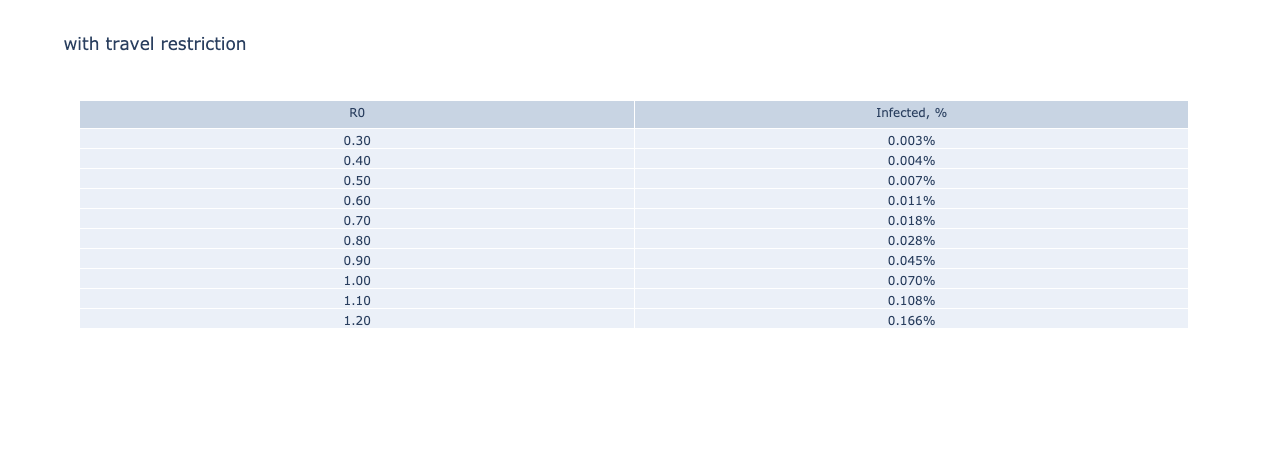

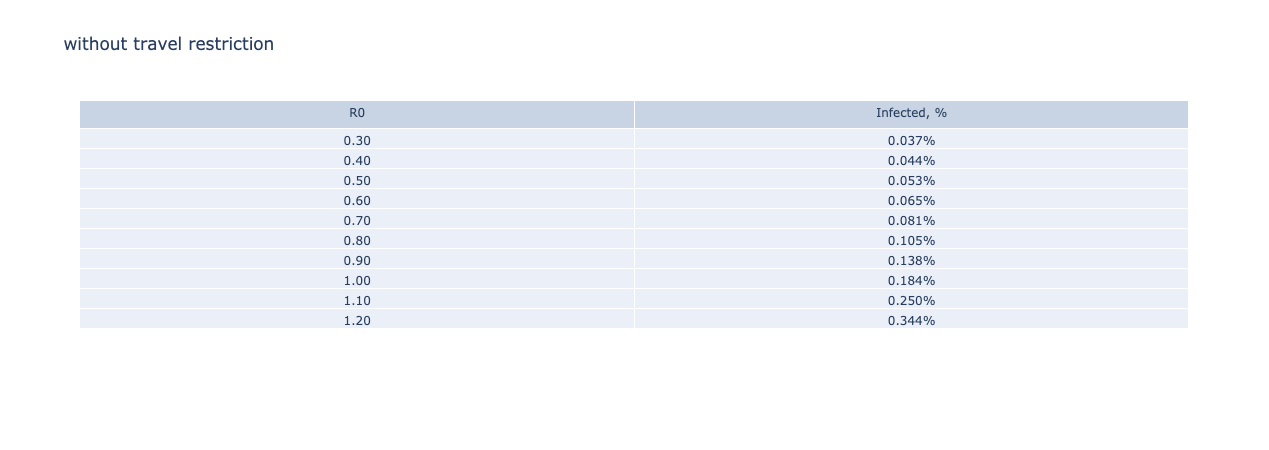

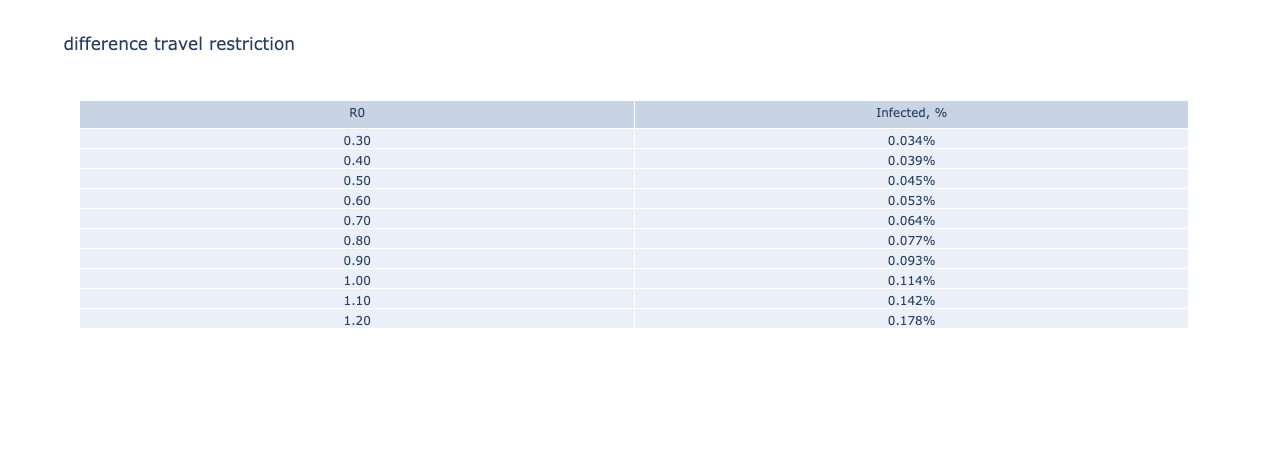

DECLARE_PANDEMIC
	FlightSEIR: 0.058%
	Data: 0.000%
	FlightSEIR: 21792.523609916956
	Data: 100.0
	Under-reporting: 21692.524%
ALL_STATES_EMERGENCY
	FlightSEIR: 0.065%
	Data: 0.004%
	FlightSEIR: 24671.343980231195
	Data: 1437.9999999999998
	Under-reporting: 1615.671%
LAST DAY
	FlightSEIR: 0.087%
	Data: 0.091%
	FlightSEIR: 32948.87788985667
	Data: 34640.0
	Under-reporting: -4.882%


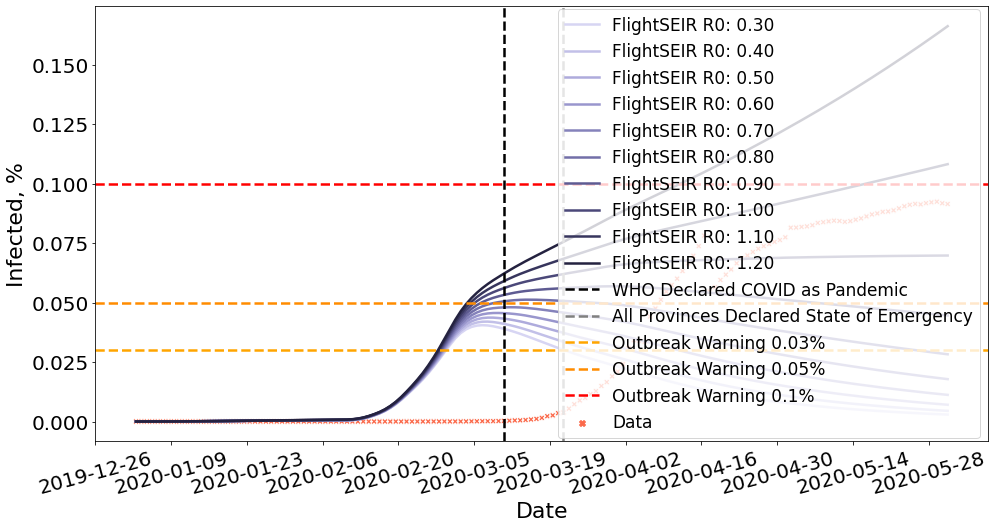

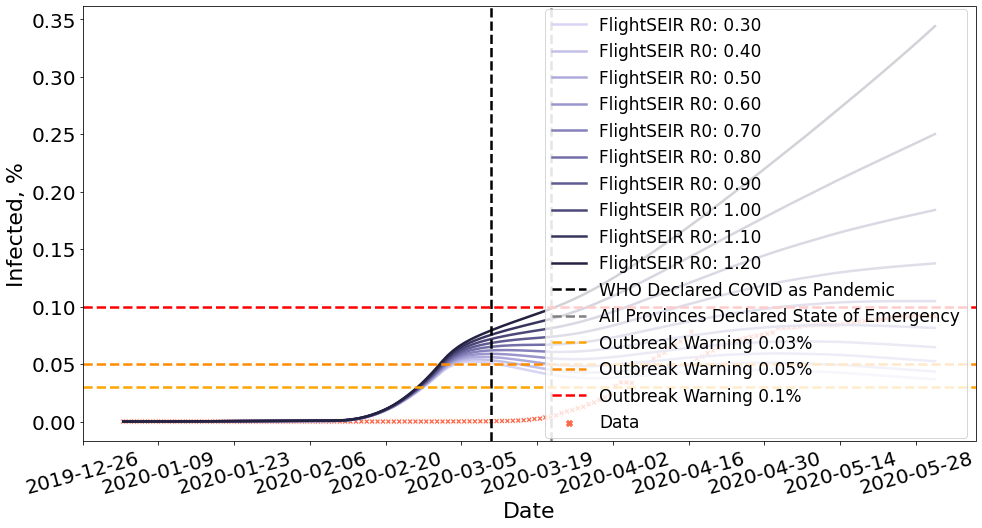

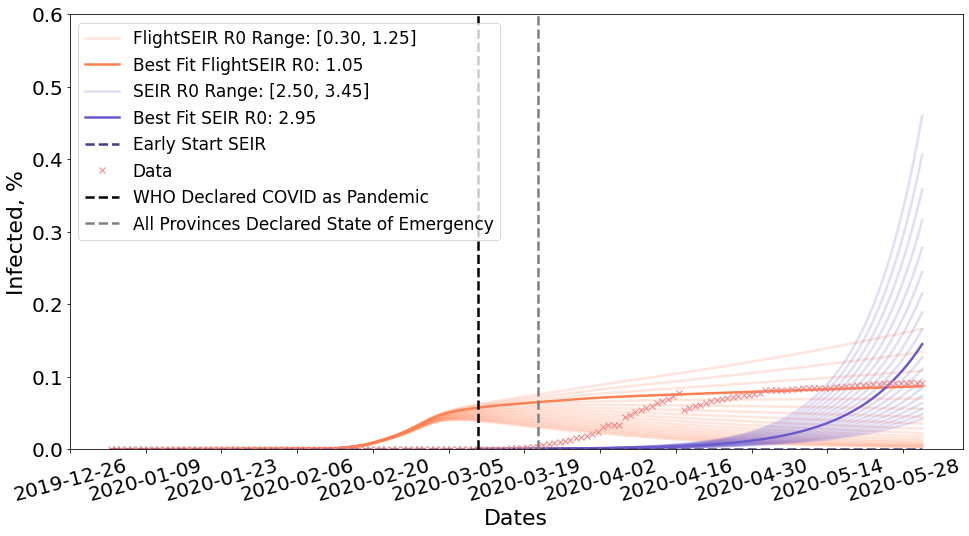

In [31]:
R0_range = np.arange(0.3, 1.3, 0.1)
R0_seir = np.arange(2.5, 3.5, 0.05)
R0_fseir = np.arange(0.3, 1.3, 0.05)
sim_canada = EarlyTimePrediction('Canada')
y1 = sim_canada.early_time_prediction(R0_range, end_date, restrict_travel=True)
y2 = sim_canada.early_time_prediction(R0_range, end_date, restrict_travel=False)
show_table(R0_range, y1[:-1, -1], "with travel restriction")
show_table(R0_range, y2[:-1, -1], "without travel restriction")
show_table(R0_range, y2[:-1, -1] - y1[:-1, -1], "difference travel restriction")
sim_canada.estimate_R0(R0_seir, R0_fseir, end_date)

DECLARE_PANDEMIC
	FlightSEIR: 0.055%
	Data: 0.000%
	FlightSEIR: 8150.904877119567
	Data: 41.0
	Under-reporting: 19780.256%
ALL_STATES_EMERGENCY
	FlightSEIR: 0.052%
	Data: 0.003%
	FlightSEIR: 7589.592424526649
	Data: 420.0
	Under-reporting: 1707.046%
LAST DAY
	FlightSEIR: 0.021%
	Data: 0.026%
	FlightSEIR: 3086.855430971822
	Data: 3834.0
	Under-reporting: -19.487%


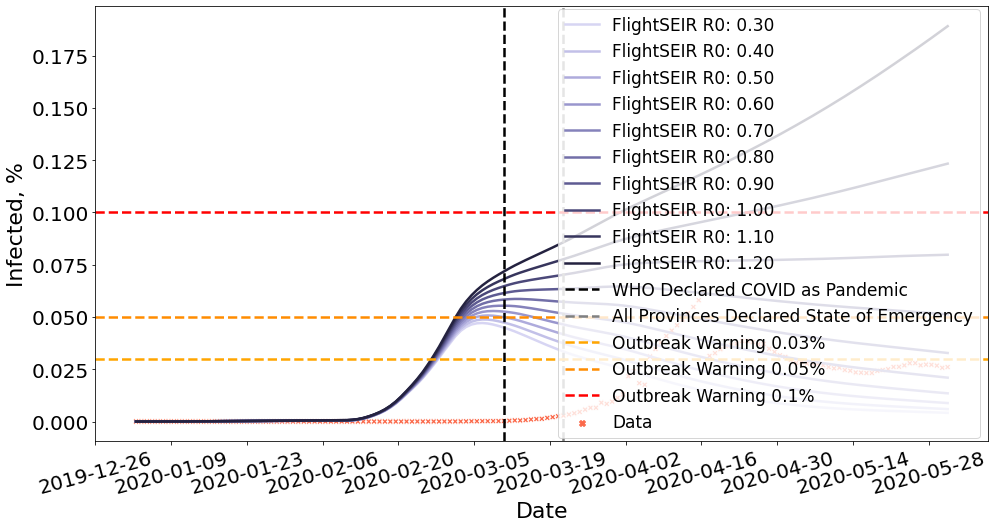

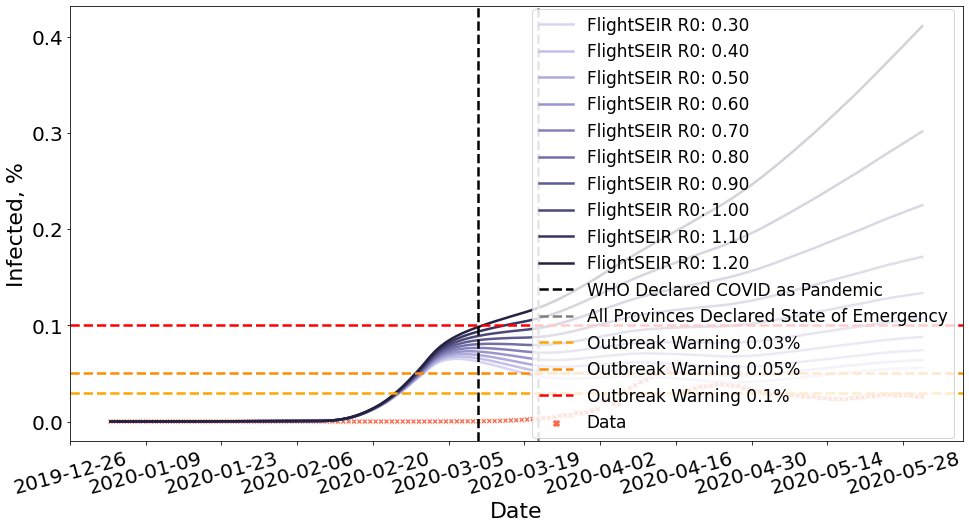

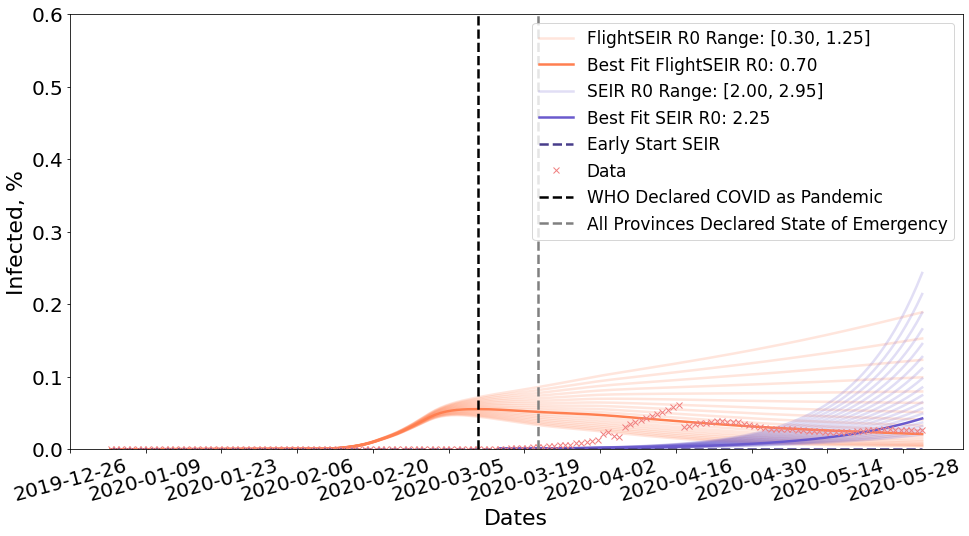

In [32]:
R0_range = np.arange(0.3, 1.3, 0.1)
R0_seir = np.arange(2.0, 3.0, 0.05)
R0_fseir = np.arange(0.3, 1.3, 0.05)
sim_on = EarlyTimePrediction('Ontario')
sim_on.early_time_prediction(R0_range, end_date, restrict_travel=True)
sim_on.early_time_prediction(R0_range, end_date, restrict_travel=False)
sim_on.estimate_R0(R0_seir, R0_fseir, end_date)